# **BA820 Project M2 — Alone (TV Show)**

Team: A1_08

Datasets used: episodes.csv

Goal: Conduct exploratory analysis of episode-level engagement metrics to understand the distribution and relationships among reach (viewers), perceived quality (imdb_rating), and engagement intensity (n_ratings), surface meaningful patterns and anomalies (e.g., reach–quality misalignment and potential under-exposed high-quality episodes), and motivate an unsupervised segmentation approach (K-Means) that produces actionable engagement profiles to guide promotion, recommendation placement, and repackaging decisions.

**Focus Question (Business):**

How should we prioritize episodes for promotion, recommendation placement, and repackaging to maximize audience impact?

Using three episode-level engagement metrics—
- `viewers` (reach),
- `imdb_rating` (perceived quality),
- `n_ratings` (engagement intensity),
can we identify distinct engagement profiles (e.g., “blockbusters,” “hidden gems,” and “low-engagement risk” episodes) that support actionable marketing and curation decisions?

**Method (Unsupervised):**

We apply K-Means clustering on standardized engagement features (`log1p(viewers)`, `imdb_rating`, `log1p(n_ratings)`) to segment episodes into interpretable profiles. We use elbow and silhouette as guidance for selecting `k`, and use PCAas 2D visualization tools to inspect cluster structure and support interpretation (not as the clustering method). We then translate each profile into business actions (promote / resurface / reposition / deprioritize).


**Note:**

This notebook builds on M1’s audience engagement framing (EDA 3), but all preprocessing choices, clustering, model selection, and visualizations are newly conducted for M2.

### **Imports**

In [33]:

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd



###**Load Episodes**

In [34]:
BASE_URL = "https://raw.githubusercontent.com/Marcusshi/BA820-A1-08/main/data/alone_tv_show/"
episodes = pd.read_csv(BASE_URL + "episodes.csv")

print("Episodes:", episodes.shape)
episodes.head()

Episodes: (98, 11)


,version,season,episode_number_overall,episode,title,air_date,viewers,quote,author,imdb_rating,n_ratings
0,US,1,1,1,And So It Begins,2015-06-18,1.582,I went to the woods because I wished to live d...,Henry David Thoreau,7.5,135.0
1,US,1,2,2,Of Wolf and Man,2015-06-25,1.697,If you live among wolves you have to act like ...,Nikita Khrushchev,7.7,110.0
2,US,1,3,3,The Talons of Fear,2015-07-02,1.864,Extinction is the rule. Survival is the except...,Carl Sagan,7.7,104.0
3,US,1,4,4,Stalked,2015-07-09,2.082,"Hunger, love, pain, fear are some of those inn...",Albert Einstein,7.7,104.0
4,US,1,5,5,Winds of Hell,2015-07-16,2.082,"The strong survive, but the courageous triumph.",Michael Scott,7.6,99.0


### **M1 Recap: Missingness and usable sample size**

**What we found (from the cells above):**
- Missing values: `viewers` = **15**, `imdb_rating` = **5**, `n_ratings` = **5**
- Complete cases for joint analysis: **83 / 98** episodes

**Decision:**

- Our effective sample size is 83, which is sufficient for exploratory segmentation using 3 numeric features.

###**Minimal Cleaning + Standardize Column Names**

In our M1 notebook, we standardized column names (lowercase, underscores).
I reuse the same logic here to ensure consistency with M1.
(All analyses below are new for M2.)

In [35]:
episodes = episodes.copy()
episodes.columns = (episodes.columns.str.strip()
                                 .str.lower()
                                 .str.replace(" ", "_")
                                 .str.replace("-", "_"))

if "air_date" in episodes.columns:
    episodes["air_date"] = pd.to_datetime(episodes["air_date"], errors="coerce")

for col in ["viewers", "imdb_rating", "n_ratings"]:
    if col in episodes.columns:
        episodes[col] = pd.to_numeric(episodes[col], errors="coerce")

episodes[["viewers","imdb_rating","n_ratings"]].isna().mean().mul(100).round(1)

,0
viewers,15.3
imdb_rating,5.1
n_ratings,5.1


### **Where M1 EDA3 Was Limited (and What M2 Extends)**

M1 EDA3 provided useful descriptive trends (viewers over time, rating patterns), but it had limitations for decision-making:

1) Mostly descriptive:
   - It showed trends, but did not identify repeatable engagement profilesacross episodes.

2) Features were not analyzed jointly:
   - `viewers` and `imdb_rating` were often viewed separately, but business questions require combinations
     (e.g., high reach + low quality vs low reach + high quality).

3) No segmentation / model selection:
   - M1 did not estimate segments or validate segmentation choices

M2 extension:
We will jointly use `viewers`, `imdb_rating`, `n_ratings` to discover interpretable clusters (profiles), then interpret them in business terms.

### **Joint structure (reach vs quality)**

Previous plots mostly looked at variables separately or by season.
For business decisions, we care about combinations:

We also care about how much attention/discussion an episode receives.
Since 3D plots are harder to read, we can encode `n_ratings` as marker size.

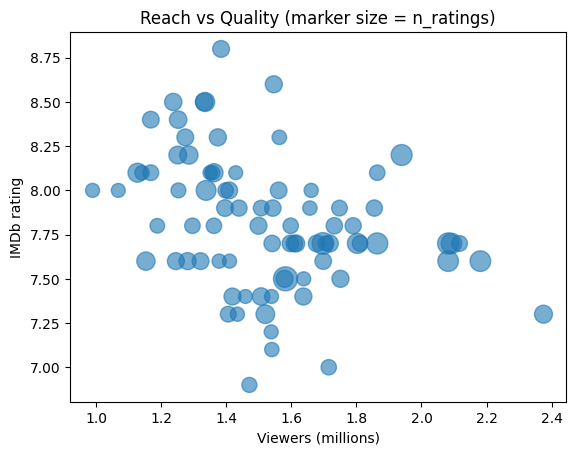

In [36]:
sizes = df_feat["n_ratings"].values
sizes = (sizes / sizes.max()) * 300

plt.figure()
plt.scatter(df_feat["viewers"], df_feat["imdb_rating"], s=sizes, alpha=0.6)
plt.xlabel("Viewers (millions)")
plt.ylabel("IMDb rating")
plt.title("Reach vs Quality (marker size = n_ratings)")
plt.show()

**Finding (Reach vs Quality):**
When we encode `n_ratings` as marker size, we see that high engagement intensity does not always coincide with the highest IMDb ratings. Several of the largest markers appear in the mid-rating range (~7.4–7.8) with moderate-to-high reach, suggesting a “high exposure / high discussion but mixed quality” pattern. Meanwhile, many high-rated episodes (8.2+) sit at mid reach levels. This reinforces the need to segment episodes into interpretable engagement profiles using all three metrics (`viewers`, `imdb_rating`, `n_ratings`).

### **Compare raw vs log-transformed**

Goal:
Using  `viewers` & `n_ratings`
to reduce skew so that distances reflect typical differences rather than a few extreme episodes.

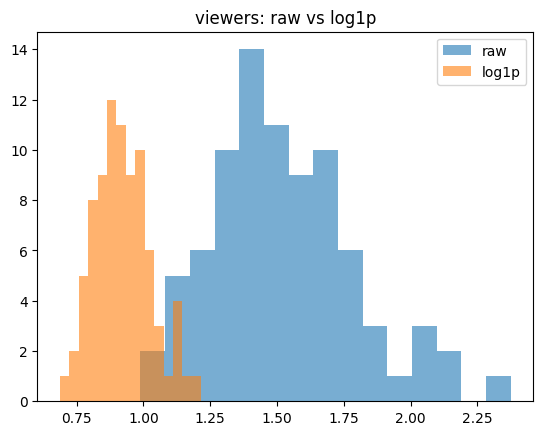

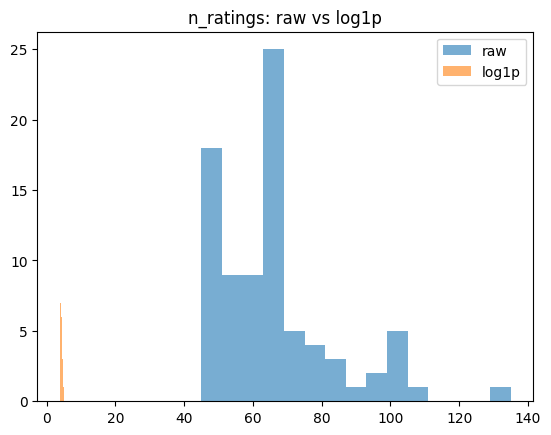

In [37]:
df_model = df_feat.copy()
df_model["viewers_log"] = np.log1p(df_model["viewers"])
df_model["n_ratings_log"] = np.log1p(df_model["n_ratings"])

for raw_col, log_col in [("viewers", "viewers_log"), ("n_ratings", "n_ratings_log")]:
    plt.figure()
    plt.hist(df_model[raw_col], bins=15, alpha=0.6, label="raw")
    plt.hist(df_model[log_col], bins=15, alpha=0.6, label="log1p")
    plt.title(f"{raw_col}: raw vs log1p")
    plt.legend()
    plt.show()

**EDA Finding:** `viewers` and `n_ratings` exhibit right-tail behavior. `log1p` compresses extreme values so that distance-based clustering is less dominated by a few unusually large episodes.

### **standardize**


In [38]:
X_raw = df_model[["viewers_log", "imdb_rating", "n_ratings_log"]].copy()
display(X_raw.describe())

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

print("Means after scaling:", X_mean)
print("Stds after scaling:", X_std)

,viewers_log,imdb_rating,n_ratings_log
count,83.000000,83.000000,83.000000
mean,0.921919,7.813253,4.171709
std,0.104434,0.368176,0.241419
min,0.687632,6.900000,3.828641
25%,0.851856,7.600000,4.007168
50%,0.919087,7.800000,4.174387
75%,0.988605,8.050000,4.269673
max,1.216395,8.800000,4.912655


Means after scaling: [ 8.79065896e-17 -9.52718493e-16  1.31889145e-15]
Stds after scaling: [1. 1. 1.]


### **Dimensionality Reduction-PCA**

Explained variance ratio: [0.48060864 0.35944739 0.15994397]
Cumulative explained variance: [0.48060864 0.84005603 1.        ]


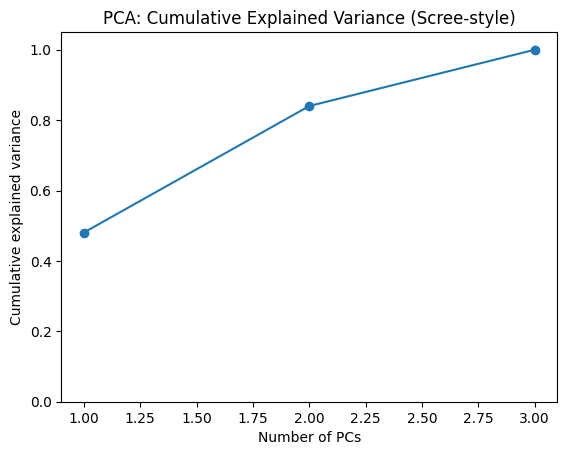

In [39]:
pca_full = PCA(random_state=42)
pca_full.fit(X)

explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

print("Explained variance ratio:", explained)
print("Cumulative explained variance:", cum_explained)

plt.figure()
plt.plot(range(1, len(explained)+1), cum_explained, marker="o")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative explained variance")
plt.title("PCA: Cumulative Explained Variance (Scree-style)")
plt.ylim(0, 1.05)
plt.show()

**EDA Finding (PCA):** PCA shows that the first two components explain about **84%** of the total variance (PC1 ≈ 48%, PC2 ≈ 36%). This suggests a **2D PCA projection** is a reasonable summary for visualization and interpretation after clustering.

## **Experiment: Choosing the number of clusters (k)**

We use K-Means to create episode-level engagement profiles using features:
- `viewers_log` (reach)
- `imdb_rating` (perceived quality)
- `n_ratings_log` (engagement intensity)

We test k in a reasonable range and inspect:
- **Elbow (inertia/SSE)**: diminishing returns as k increases
- **Silhouette score**: cohesion vs separation (not the only criterion)

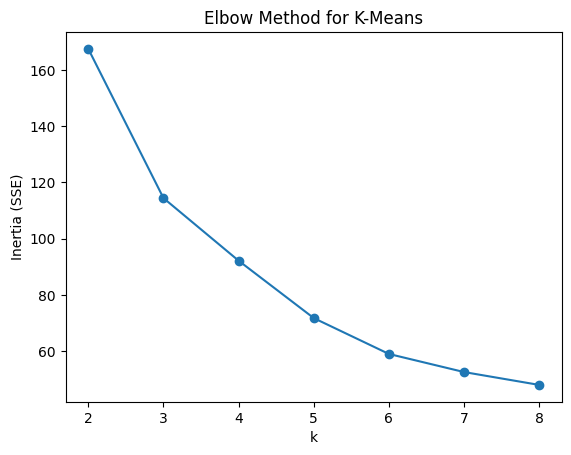

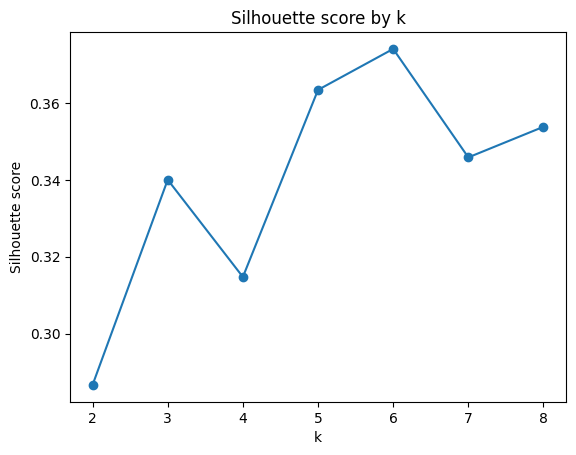

,k,inertia,silhouette
4,6,58.948044,0.374089
3,5,71.714442,0.363426
6,8,47.933483,0.353820
5,7,52.509716,0.345858
1,3,114.414871,0.340034
2,4,92.136086,0.314736
0,2,167.504674,0.286637


In [40]:
ks = range(2, 9)
inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels_k = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels_k))

plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for K-Means")
plt.show()

plt.figure()
plt.plot(list(ks), silhouettes, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score by k")
plt.show()

results_k = pd.DataFrame({"k": list(ks), "inertia": inertias, "silhouette": silhouettes})
results_k.sort_values("silhouette", ascending=False)

### **Choosing K — Short Findings**

Silhouette improved from k=3 (0.340) to k=5 (0.363) and peaked at k=6 (0.374). k=5 provides clearer business profiles (e.g., blockbusters vs hidden gems vs baseline) without over-fragmenting the dataset into small clusters.


In [41]:
k_final = 5

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=20)
labels = kmeans.fit_predict(X)

episodes_model = df_feat.copy()
episodes_model["cluster"] = labels

episodes_model.head()

,viewers,imdb_rating,n_ratings,cluster
0,1.582,7.5,135.0,2
1,1.697,7.7,110.0,2
2,1.864,7.7,104.0,2
3,2.082,7.7,104.0,2
4,2.082,7.6,99.0,2


In [42]:
summary = (episodes_model
           .groupby("cluster")
           .agg(
               n_episodes=("cluster", "size"),
               viewers_mean=("viewers", "mean"),
               viewers_median=("viewers", "median"),
               imdb_mean=("imdb_rating", "mean"),
               imdb_median=("imdb_rating", "median"),
               n_ratings_mean=("n_ratings", "mean"),
               n_ratings_median=("n_ratings", "median"),
           )
           .sort_values("n_episodes", ascending=False))

summary

,n_episodes,viewers_mean,viewers_median,imdb_mean,imdb_median,n_ratings_mean,n_ratings_median
cluster,,,,,,,
3,27,1.670296,1.6570,7.733333,7.70,62.259259,63.0
0,20,1.290350,1.3085,7.920000,8.00,56.200000,55.5
4,14,1.304643,1.3085,8.350000,8.35,74.000000,71.5
1,12,1.495583,1.4650,7.308333,7.35,50.333333,47.0
2,10,1.969700,2.0105,7.670000,7.70,101.800000,100.5


**Implications:**

 Cluster 2 represents “blockbusters” with the highest reach and the strongest buzz (highest viewers and n_ratings) but only mid-level ratings. Cluster 4 represents “quality leaders / hidden gems” with the highest IMDb ratings but relatively low reach, suggesting under-exposed high-quality content that may benefit from resurfacing. Cluster 1 shows the lowest ratings and low engagement intensity, indicating potential content risk. Clusters 0 and 3 represent quieter favorites and mainstream baseline episodes, respectively. These profiles translate directly into actions such as promotion prioritization, recommendation placement, and repackaging strategies.

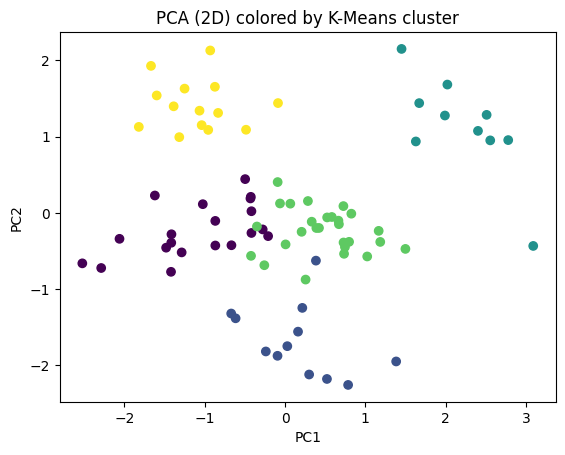

Explained variance ratio: [0.48060864 0.35944739] | sum = 0.8400560319301265


In [43]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA (2D) colored by K-Means cluster")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_, "| sum =", pca.explained_variance_ratio_.sum())

**Finding (PCA visualization):**

The PCA plot shows clear cluster structure in 2D. At least two clusters form well-separated groups (one in the upper-right region and one in the upper-left region), indicating distinct episode profiles in the standardized space. A “baseline” cluster concentrates near the center with some overlap, which is expected for typical episodes that sit closer to overall averages.

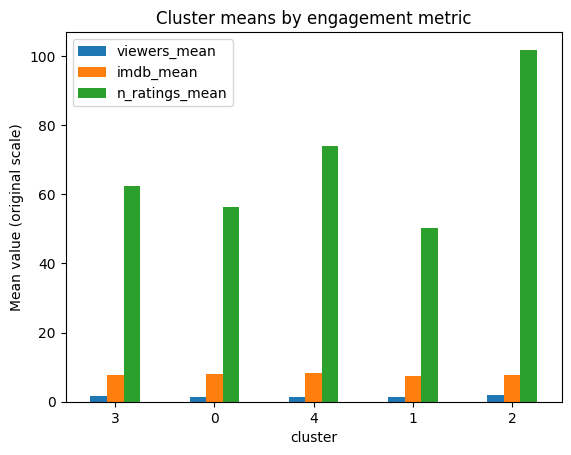

In [44]:
plot_summary = summary[["viewers_mean","imdb_mean","n_ratings_mean"]].copy()
plot_summary.plot(kind="bar")
plt.title("Cluster means by engagement metric")
plt.ylabel("Mean value (original scale)")
plt.xticks(rotation=0)
plt.show()

**This plot may not work well (visualization limitation):**
This bar chart puts `viewers_mean` , `imdb_mean` , and `n_ratings_mean` on the same y-axis. Because the metrics are on very different scales, the `n_ratings` bars dominate visually and the differences in `viewers` and `imdb_rating` appear nearly flat. As a result, the plot can be misleading and is not ideal for comparing clusters across all three dimensions.

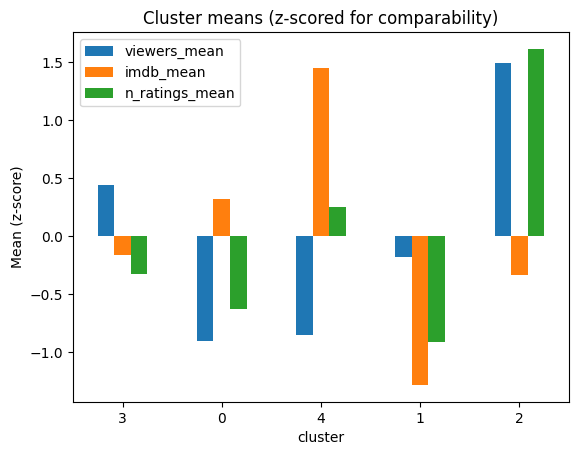

In [45]:
plot_summary_z = summary[["viewers_mean","imdb_mean","n_ratings_mean"]].copy()
plot_summary_z = (plot_summary_z - plot_summary_z.mean()) / plot_summary_z.std()

plot_summary_z.plot(kind="bar")
plt.title("Cluster means (z-scored for comparability)")
plt.ylabel("Mean (z-score)")
plt.xticks(rotation=0)
plt.show()

**Finding:**

The z-scored means highlight clear trade-offs: Cluster 2 is high reach/high buzz but not top-rated; Cluster 4 is the highest-rated but under-reached; Cluster 1 is low on both quality and engagement; Clusters 0 and 3 are quieter and more baseline profiles.

In [46]:

episodes_complete = episodes.dropna(subset=["viewers","imdb_rating","n_ratings"]).copy()
episodes_complete["cluster"] = labels

episodes_complete[episodes_complete["cluster"]==4][["season","episode","title","viewers","imdb_rating","n_ratings"]].sort_values("imdb_rating", ascending=False).head(10)

,season,episode,title,viewers,imdb_rating,n_ratings
64,6,11,Fire and Ice,1.384,8.8,66.0
74,7,10,Pins and Needles,1.546,8.6,68.0
75,7,11,Over the Edge,1.335,8.5,85.0
73,7,9,The Wolves,1.237,8.5,70.0
70,7,6,The Musk Ox,1.332,8.5,72.0
58,6,5,The Kill,1.168,8.4,65.0
72,7,8,Up In Smoke,1.252,8.4,71.0
69,7,5,The Rock,1.374,8.3,68.0
71,7,7,Snared,1.274,8.3,66.0
66,7,2,The Rock House,1.285,8.2,78.0


**Action idea:**

These episodes can be prioritized for “best-of” collections, targeted recommendations, and short-form recap clips to increase reach without relying on new production.

## **Interpreting Engagement Profiles**

The clustering results reveals:

- A clear “blockbuster / high-buzz” profile emerges with high reach(`viewers`) and high engagement intensity (`n_ratings`), even when `imdb_rating` is only mid-level. This suggests some episodes exposion are not necessarily because they are the most highly rated.
- A distinct “hidden gems” profile shows the highest perceived quality (`imdb_rating`) but below-average reach (`viewers`). These episodes appear to be well-liked by the viewers who watch them, yet are under-exposed.
- A “low-engagement risk” profile combines lower `imdb_rating`and lower `n_ratings`, indicating episodes that may be weaker for retention or word-of-mouth when placed in prominent recommendation slots.


## **Limitations and Sensitivity**

- **Proxy metrics:** `imdb_rating` and `n_ratings` are IMDb-based proxies and can reflect selection effects (who chooses to rate) only at this website rather than pure quality.
- **Unsupervised interpretation:** Clusters describe structure and co-movement in metrics; they do not establish causality. A “hidden gem” label does not guarantee that promotion will increase reach.

## **What Surprised Me**

- Highest-reach episodes were not the highest-rated. I initially expected reach (`viewers`) and perceived quality (`imdb_rating`) to align more closely, but the clustering separated a high reach from a highest-rated profile with lower reach. This indicates that scale and satisfaction can be different levers.

- “hidden gems” often still showed meaningful engagement intensity (`n_ratings`) despite lower reach. This suggests **under-exposure may be a bigger issue than weak audience response**, making resurfacing and repackaging a plausible strategy for this profile.

- Overall, this shifted my framing from “find the best episodes” to “match actions to profiles”: promote blockbusters for reach, resurface hidden gems for quality signaling, and deprioritize low-engagement risk episodes in recommendations.


## **What Did Not Work / Iterations**

An early attempt to compare cluster means on the original metric scales produced a misleading bar chart because (`n_ratings` dominated the axis and flattened differences in `viewers` and `imdb_rating`). This motivated the improved z-scored profile plot, which enables fair cross-metric comparison.

I also found that clustering on raw (unlogged) `viewers` and `n_ratings` made results overly influenced by a small number of extreme episodes. Applying `log1p` before standardization reduced tail dominance and produced more stable profiles.

Finally, choosing too few clusters (e.g., k=3) merged distinct business cases (such as “hidden gems” vs “quiet favorites”), while too many clusters reduced interpretability. We selected k=5 as a balance between separation metrics and actionable segmentation.

**What has not been done yet:** This M2 analysis focuses only on three engagement metrics (`viewers`, `imdb_rating`, `n_ratings`) and does not incorporate context variables such as `season`, `air_date`, episode position, or theme/content metadata that could explain why an episode falls into a given profile. We also did not run any causal validation (e.g., A/B tests) to confirm that promoting a “hidden gem” increases reach.

**What we plan next:** First, we will link clusters back to episode context (season and episode position) to see whether certain profiles are systematically driven by scheduling or season-level differences rather than episode quality. Second, we will create a practical candidate list (e.g., top-rated “hidden gems”) and design a small resurfacing experiment to measure incremental views and engagement.

**Open questions:** Are low-reach episodes low because of limited exposure (placement/timing) or because they appeal to a niche audience? Do “blockbusters” achieve scale primarily through distribution advantages, or do they reflect content that is broadly appealing even at similar placement? Are there any other features affecting them but we don't konw yet?









**How current findings guide next steps:** The clustering profiles provide a clear prioritization logic: validate the ROI of resurfacing the high-quality/under-reached profile (“hidden gems”), keep high reach/high buzz episodes as promotion anchors, and avoid over-exposing low-quality/low-engagement risk episodes in prime recommendation slots until further review.